# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Project Overview:
This is the Udacity Data Scientist Nanodegree Capstone project. The goal is to alter realistic datasets with Spark to create appropriate churn prediction characteristics. For the hypothetical music streaming service Sparkify (similar to Spotify and Pandora). The whole dataset was only available by subscribing for an AWS subscription, thus this project was done utilizing Udacity's workspace. A smaller.json dataset was given.

## Problem Statement:
Churn is a serious worry for many businesses. Some users will naturally cease utilizing the service, but if this number is too large, it can hurt businesses regardless of revenue sources (ad sales, subscriptions or a mix of both). With this in mind, the ability for businesses to predict churn by identifying at-risk clients is critical since it allows them to take steps to prevent the loss of customers, such as targeted offers or discounts. 

Machine learning models built on historical data can help us understand churn signals and anticipate it before it happens.


Here the issue is predicting which Sparkify music streaming consumers would abandon the service. To accomplish this, I'll use Spark to create a machine learning model. Because there are only two possible outcomes, 'churn' and 'not churn,' we can use supervised learning to solve this binary classification problem.

In [34]:
# import libraries
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col,isnan, when, count
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
%matplotlib inline

In [35]:
# create a Spark session
spark = SparkSession \
        .builder\
        .master("local")\
        .appName("Sparkify_Project")\
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [36]:
event_data = spark.read.json("mini_sparkify_event_data.json")

In [37]:
event_data.limit(20).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [38]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [39]:
event_data.count()

286500

In [40]:
event_data.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [41]:
event_data.limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [42]:
#check NULL values for all columns
event_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_data.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


there is no null values on the level of sessionid and userid

In [43]:
event_data.select(F.countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   226|
+----------------------+



In [44]:
event_data.filter(event_data["userId"] == "").count()

8346

there is some rows having empty string in userid columns

In [45]:
event_data.select("auth").groupby("auth").count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [46]:
event_data.filter(event_data["userId"] == "").select("auth").groupby("auth").count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



all empty string userid rows for looged out/ guest users

In [47]:
event_data_final = event_data.where(event_data["userId"] != "")

In [48]:
event_data_final.select(F.countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



In [49]:
event_data_final.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [50]:
event_data_final.limit(20).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [51]:
event_data_final.groupby("page").count().show(truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |10082 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |495   |
|Settings                 |1514  |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1454  |
|Upgrade                  |499   |
|Error                    |252   |
|Submit Upgrade           |159   |
+-------------------------+------+



In [52]:
event_data_final.createOrReplaceTempView("event_data_final")

In [53]:
churn_user = spark.sql("""
            SELECT 
                USERID,
                MAX(CHURN) AS CHURN_FLAG
            FROM
                (
                SELECT
                    USERID, 
                    CASE WHEN PAGE = 'Cancellation Confirmation' THEN 1 ELSE 0 END AS CHURN
                FROM
                    event_data_final
                )
            GROUP BY 
                USERID
""")

churn_user.createOrReplaceTempView("churn_user")

In [54]:
churn_user.count()

225

In [55]:
churn_user.createOrReplaceTempView("CHURN_USER")

In [56]:
churn_df = spark.sql("""
                SELECT 
                    E.*,
                    C.CHURN_FLAG
                FROM 
                    event_data_final E
                    LEFT JOIN CHURN_USER C
                    ON E.USERID = C.USERID
""")

As suggested we've created dataframe with cancelation confirmation flag as churn flag

In [57]:
churn_df.createOrReplaceTempView("CHURN_DF")

In [58]:
churn_df.groupby("CHURN_FLAG").count().show()

+----------+------+
|CHURN_FLAG| count|
+----------+------+
|         1| 44864|
|         0|233290|
+----------+------+



In [59]:
churn_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- CHURN_FLAG: integer (nullable = true)



In [60]:
churn_df.select("userId", "CHURN_FLAG").distinct().groupby("CHURN_FLAG").count().show()

+----------+-----+
|CHURN_FLAG|count|
+----------+-----+
|         1|   52|
|         0|  173|
+----------+-----+



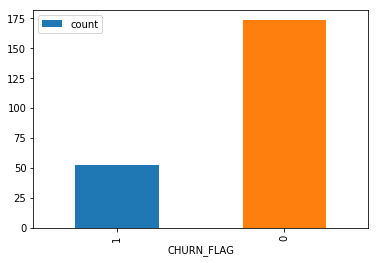

In [61]:
churn_df.select("userId", "CHURN_FLAG").distinct().groupby("CHURN_FLAG").count().toPandas().plot.bar(x='CHURN_FLAG', y='count')
plt.show()

52 users out of 225 have churn flag (23%)

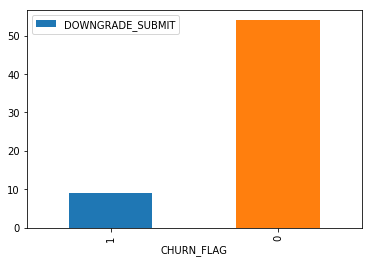

In [62]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            COUNT(*) AS DOWNGRADE_SUBMIT
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Submit Downgrade'
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='DOWNGRADE_SUBMIT')

it seems that downgrade submission doesn't have significant effect on churn flag, non-churn users submit downgrade request more frequently

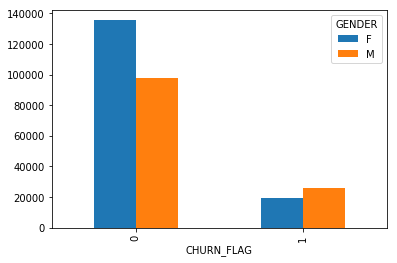

In [63]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            GENDER,
            COUNT(*) AS count
        FROM 
            CHURN_DF
        GROUP BY 
            CHURN_FLAG,
            GENDER
""").toPandas().reset_index().pivot(index = 'CHURN_FLAG', columns = 'GENDER', values = 'count').plot.bar()

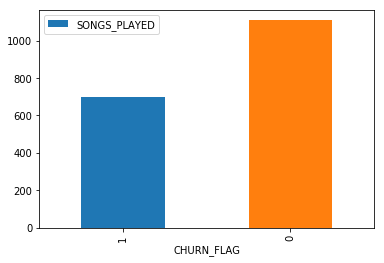

In [73]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            COUNT(*)/ COUNT(DISTINCT USERID) AS SONGS_PLAYED
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'NextSong'
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='SONGS_PLAYED')

In [65]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            PAGE,
            COUNT(*)/COUNT(DISTINCT USERID) AS AVG
        FROM 
            CHURN_DF
        GROUP BY 
            CHURN_FLAG,
            PAGE
""").toPandas().reset_index().pivot(index = 'CHURN_FLAG', columns = 'PAGE', values = 'AVG').fillna(0)

PAGE,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
CHURN_FLAG,,,,,,,,,,,,,,,,,,,
0,3.540323,22.475309,33.260606,0.0,0.0,14.436975,2.315789,8.154362,48.895349,16.005988,1108.173410,18.89172,2.470588,8.184211,1.35,1.245098,13.225806,62.894118,2.954198
1,1.806452,14.454545,20.760000,1.0,1.0,9.628571,1.454545,5.558140,32.784314,12.021739,699.884615,19.34000,1.933333,6.279070,1.00,1.103448,10.333333,37.180000,3.027027


we will include events that affect on churn flag

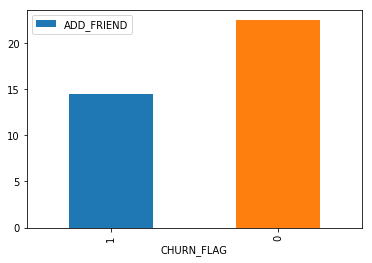

In [74]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            COUNT(*)/ COUNT(DISTINCT USERID) AS ADD_FRIEND
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Add Friend'
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='ADD_FRIEND')

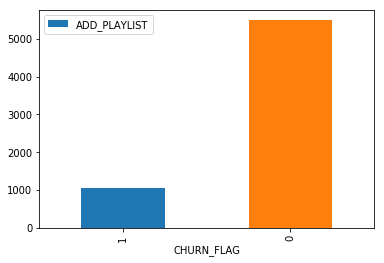

In [67]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            COUNT(*) AS ADD_PLAYLIST
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Add to Playlist'
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='ADD_PLAYLIST')

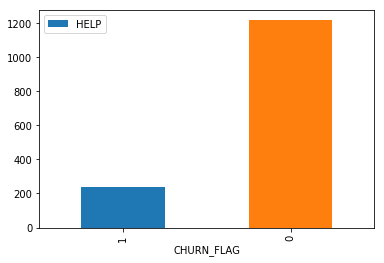

In [68]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            COUNT(*) AS HELP
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Help'
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='HELP')

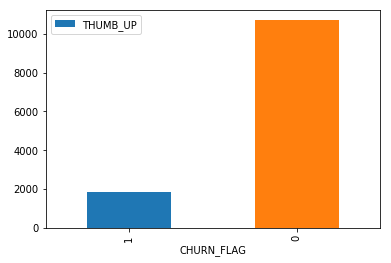

In [69]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            COUNT(*) AS THUMB_UP
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Thumbs Up'
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='THUMB_UP')

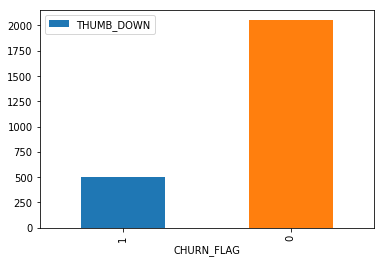

In [70]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            COUNT(*) AS THUMB_DOWN
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Thumbs Down'
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='THUMB_DOWN')

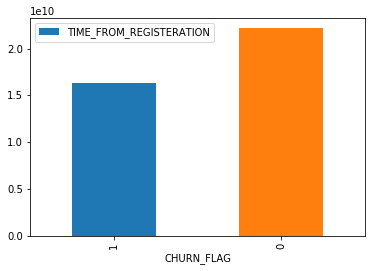

In [71]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            MAX(TS - REGISTRATION) AS TIME_FROM_REGISTERATION
        FROM 
            CHURN_DF
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='TIME_FROM_REGISTERATION')

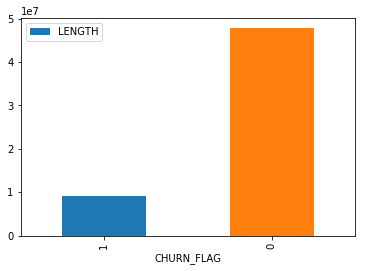

In [72]:
spark.sql("""
        SELECT 
            CHURN_FLAG,
            SUM(LENGTH) AS LENGTH
        FROM 
            CHURN_DF
        GROUP BY 
            CHURN_FLAG
""").toPandas().plot.bar(x='CHURN_FLAG', y='LENGTH')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [35]:
feature_length = spark.sql("""
        SELECT 
            USERID,
            SUM(LENGTH) AS LENGTH
        FROM 
            CHURN_DF
        GROUP BY 
            USERID
""")
feature_length.createOrReplaceTempView("feature_length")

In [36]:
feature_songs = spark.sql("""
        SELECT 
            USERID,
            COUNT(*) AS SONGS_PLAYED
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'NextSong'
        GROUP BY 
            USERID
""")

feature_songs.createOrReplaceTempView("feature_songs")

In [37]:
feature_time_from_register = spark.sql("""
        SELECT 
            USERID,
            MAX(TS - REGISTRATION) AS TIME_FROM_REGISTERATION
        FROM 
            CHURN_DF
        GROUP BY 
            USERID
""")

feature_time_from_register.createOrReplaceTempView("feature_time_from_register")

In [38]:
feature_add_friend = spark.sql("""
        SELECT 
            USERID,
            COUNT(*) AS ADD_FRIEND
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Add Friend'
        GROUP BY 
            USERID
""")

feature_add_friend.createOrReplaceTempView("feature_add_friend")

In [39]:
feature_add_playlist = spark.sql("""
        SELECT 
            USERID,
            COUNT(*) AS ADD_PLAYLIST
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Add to Playlist'
        GROUP BY 
            USERID
""")

feature_add_playlist.createOrReplaceTempView("feature_add_playlist")

In [40]:
feature_help = spark.sql("""
        SELECT 
            USERID,
            COUNT(*) AS HELP
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Help'
        GROUP BY 
            USERID
""")

feature_help.createOrReplaceTempView("feature_help")

In [41]:
feature_thumbs_up = spark.sql("""
        SELECT 
            USERID,
            COUNT(*) AS THUMB_UP
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Thumbs Up'
        GROUP BY 
            USERID
""")

feature_thumbs_up.createOrReplaceTempView("feature_thumbs_up")

In [42]:
feature_thumbs_down = spark.sql("""
        SELECT 
            USERID,
            COUNT(*) AS THUMB_DOWN
        FROM 
            CHURN_DF
        WHERE 
            PAGE = 'Thumbs Down'
        GROUP BY 
            USERID
""")

feature_thumbs_down.createOrReplaceTempView("feature_thumbs_down")

In [43]:
features_df = spark.sql("""
    SELECT 
        CU.USERID,
        CU.CHURN_FLAG,
        NVL(FL.LENGTH, 0) AS LENGTH,
        NVL(FS.SONGS_PLAYED, 0) AS SONGS_PLAYED,
        NVL(FTR.TIME_FROM_REGISTERATION, 0) AS TIME_FROM_REGISTERATION,
        NVL(FAF.ADD_FRIEND, 0) AS ADD_FRIEND,
        NVL(FAP.ADD_PLAYLIST, 0) AS ADD_PLAYLIST,
        NVL(FH.HELP, 0) AS HELP,
        NVL(FTU.THUMB_UP, 0) AS THUMB_UP,
        NVL(FTD.THUMB_DOWN, 0) AS THUMB_DOWN
    FROM 
        churn_user CU
        LEFT JOIN feature_length FL
        ON CU.USERID = FL.USERID
        LEFT JOIN feature_songs FS
        ON CU.USERID = FS.USERID
        LEFT JOIN feature_time_from_register FTR
        ON CU.USERID = FTR.USERID
        LEFT JOIN feature_add_friend FAF
        ON CU.USERID = FAF.USERID
        LEFT JOIN feature_add_playlist FAP
        ON CU.USERID = FAP.USERID
        LEFT JOIN feature_help FH
        ON CU.USERID = FH.USERID
        LEFT JOIN feature_thumbs_up FTU
        ON CU.USERID = FTU.USERID
        LEFT JOIN feature_thumbs_down FTD
        ON CU.USERID = FTD.USERID
""")

we've created dataframe with all features of interest

In [44]:
features_df.limit(2).toPandas()

,USERID,CHURN_FLAG,LENGTH,SONGS_PLAYED,TIME_FROM_REGISTERATION,ADD_FRIEND,ADD_PLAYLIST,HELP,THUMB_UP,THUMB_DOWN
0,100010,0,66940.89735,275,4807612000,4,7,2,17,5
1,200002,0,94008.87594,387,6054448000,4,8,2,21,6


In [45]:
features_df.groupby("CHURN_FLAG").count().show()

+----------+-----+
|CHURN_FLAG|count|
+----------+-----+
|         1|   52|
|         0|  173|
+----------+-----+



In [46]:
assembler = VectorAssembler(inputCols=["LENGTH", "SONGS_PLAYED", "TIME_FROM_REGISTERATION", "ADD_FRIEND", "ADD_PLAYLIST", "HELP", "THUMB_UP", "THUMB_DOWN"], outputCol="FeaturesVect")
features_df = assembler.transform(features_df)

In [47]:
scaler = MinMaxScaler(inputCol="FeaturesVect", outputCol="FeaturesStandardScaler")
scalerModel = scaler.fit(features_df)
features_df = scalerModel.transform(features_df)

In [48]:
features_df.take(1)

[Row(USERID='100010', CHURN_FLAG=0, LENGTH=66940.89735000003, SONGS_PLAYED=275, TIME_FROM_REGISTERATION=4807612000, ADD_FRIEND=4, ADD_PLAYLIST=7, HELP=2, THUMB_UP=17, THUMB_DOWN=5, FeaturesVect=DenseVector([66940.8974, 275.0, 4807612000.0, 4.0, 7.0, 2.0, 17.0, 5.0]), FeaturesStandardScaler=DenseVector([0.0333, 0.034, 0.2161, 0.028, 0.0292, 0.0435, 0.0389, 0.0667]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Metrics
The classification distribution is uneven since only 23% of users have the result churn. I picked the F1 Score measure, which is the harmonic mean of precision and recall, to account for this.

In [49]:
data = features_df.select(col("CHURN_FLAG").alias("label"), col("FeaturesStandardScaler").alias("features"))
data.head()

Row(label=0, features=DenseVector([0.0333, 0.034, 0.2161, 0.028, 0.0292, 0.0435, 0.0389, 0.0667]))

In [63]:
data.count()

225

In [62]:
rest,validation = data.randomSplit([0.9, 0.1], seed=42)

In [51]:
def model_score(trained_model, validation):
    """
    This function is to evaluate model using accuracy and f1-score metrics
    INPUT : 
    trained_model : model we need to evaluate
    validation : validation dataset to evaluate model on 
    OUTPUT :
    accuracy : model accuracy on validation dataset
    f1_score : f1 score for the model
    """
    result = trained_model.transform(validation)


    accuracy = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(result.select(col('label'), col('prediction')))

    f1_score = MulticlassClassificationEvaluator(metricName='f1').evaluate(result.select(col('label'), col('prediction')))
    
    return accuracy, f1_score

In [66]:
lr =  LogisticRegression(labelCol='label', featuresCol='features')
rf =  RandomForestClassifier(labelCol='label', featuresCol='features')
gbt =  GBTClassifier(labelCol='label', featuresCol='features')
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')

lr_trained = lr.fit(rest)
rf_trained = rf.fit(rest)
gbt_trained = gbt.fit(rest)
dt_trained = dt.fit(rest)

lr_accuracy, lr_f1 = model_score(lr_trained,validation)
rf_accuracy, rf_f1 = model_score(rf_trained,validation)
gbt_accuracy, gbt_f1 = model_score(gbt_trained,validation)
dt_accuracy, dt_f1 = model_score(dt_trained, validation)

print("logistic regression : accuracy({}), f1score({})".format(lr_accuracy, lr_f1))
print("random forest : accuracy({}), f1score({})".format(rf_accuracy, rf_f1))
print("gradient boosting : accuracy({}), f1score({})".format(gbt_accuracy, gbt_f1))
print("decision tree : accuracy({}), f1score({})".format(dt_accuracy, dt_f1))

logistic regression : accuracy(0.625), f1score(0.53125)
random forest : accuracy(0.75), f1score(0.7227272727272727)
gradient boosting : accuracy(0.6875), f1score(0.6346618357487923)
decision tree : accuracy(0.6875), f1score(0.6346618357487923)


In [71]:
rf_new =  RandomForestClassifier(labelCol='label', featuresCol='features')

paramGrid = ParamGridBuilder() \
    .addGrid(rf_new.maxDepth,[3, 5, 7]) \
    .build()


crossval = CrossValidator(estimator=rf_new,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

model = crossval.fit(rest)
model.avgMetrics

[0.7300636533474125, 0.7581814844263598, 0.7488547397867442]

In [73]:
rf_new =  RandomForestClassifier(labelCol='label', featuresCol='features', maxDepth=5)

rf_trained = rf_new.fit(rest)

rf_accuracy, rf_f1 = model_score(rf_trained,validation)

print("random fores : accuracy({}), f1score({})".format(rf_accuracy, rf_f1))

random fores : accuracy(0.75), f1score(0.7227272727272727)


# Conclusion
We deployed Spark machine learning models to estimate churn for Sparkify's users using previous log data.

## Refliction:
With 75% and 0.72 f1 score, we developed a model that can detect consumers at danger of churning. This is carried out by To acquire a feel for the data, I first did some data exploration. After then, I started to add features. I trained four distinct types of models once I had a dataset. I used several hyperparameters and cross-validation to fine-tune the Random Forest classifier, which performed the best.



The model evaluation results were acceptable but not ideal, therefore we need to make some changes to get better outcomes.


## Improvments:
* Because the dataset in question has an imbalanced prolem, resampling approaches could help to improve its performance. Working with more data could also enhance performance and allow for a more thorough search of the hyper-parameter space, making this model even more reliable and helpful. For example, the model could be run every day (or week, depending on computer capability), and targeted messages or discounts may be delivered to those who were indicated as likely to churn. 

* To avoid wasting money, A/B testing should be used to determine which action to take. This ensures rigor and statistical significance.

* As the user base and consumer behavior evolve, it is critical that this model be re-trained on a regular basis to avoid making decisions based on obsolete data.

* It would be interesting to duplicate this study on a bigger chunk of the log data if Sparkify had access to a cluster (for example, AWS or IBM Cloud).


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.